## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Neural Networks notebook (lab 6).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1135]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
import pandas as pd

import typing
%matplotlib inline

In [1136]:
iris_db = datasets.load_iris(as_frame=True)
# sn.pairplot(iris_db.data)

In [1137]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [1138]:
col = iris_db.data.columns.values
col

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [1139]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red"><u>**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font></u>

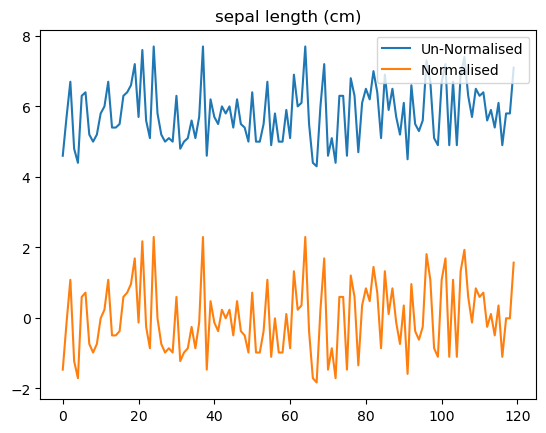

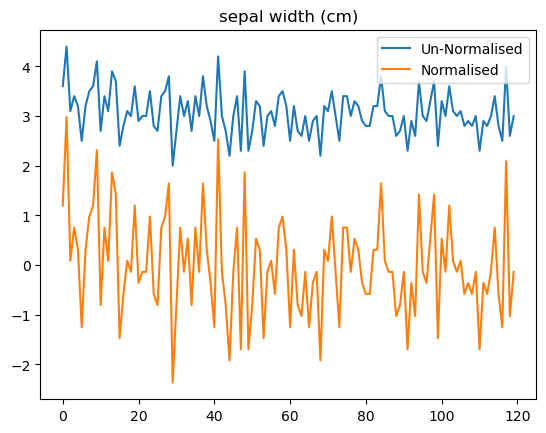

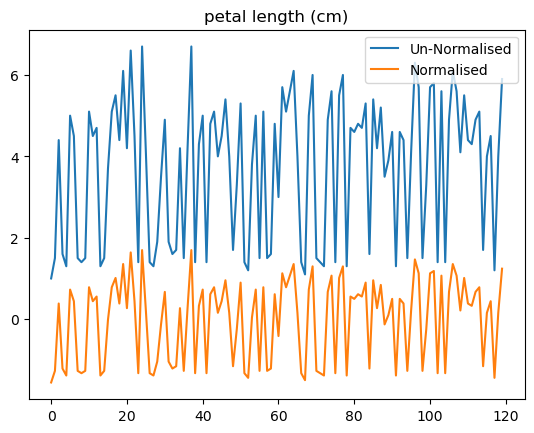

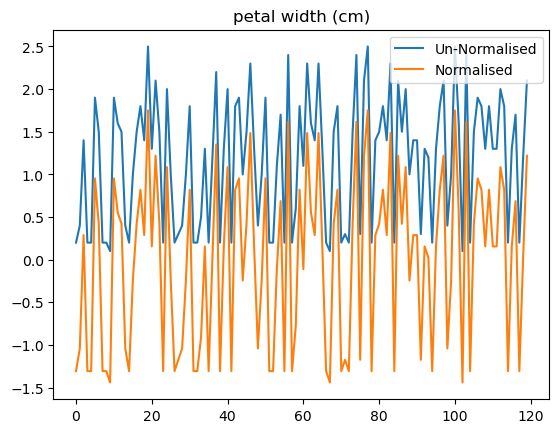

In [1140]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x-mu)/sigma

# find mean and standard deviation
x_train_mean = torch.mean(x_train,dim=0)
x_train_std = torch.std(x_train,dim=0)

# Normalising the training and testing set
x_train_normalised = norm_set(x_train,x_train_mean,x_train_std)
x_test_normalised = norm_set(x_test,x_train_mean,x_train_std)


for i, title in enumerate(col):
    plt.title(title)
    plt.plot(x_train[:,i], label='Un-Normalised')
    plt.plot(x_train_normalised[:,i], label='Normalised')
    plt.legend()
    plt.legend(loc='upper right')
    plt.show()

x_train= x_train_normalised
x_test= x_test_normalised

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

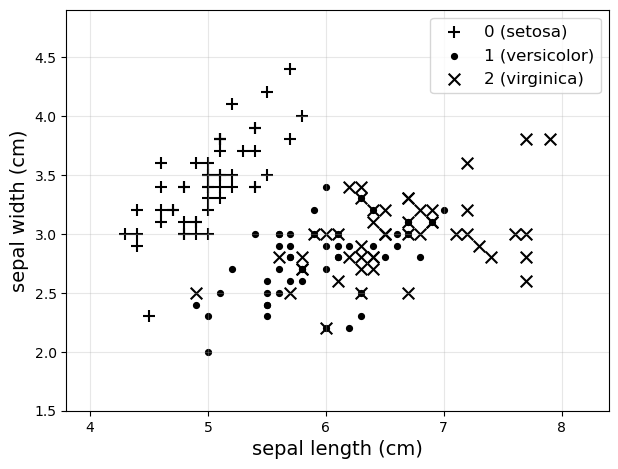

In [1141]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [1142]:
x_train.shape

torch.Size([120, 4])

In [1143]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

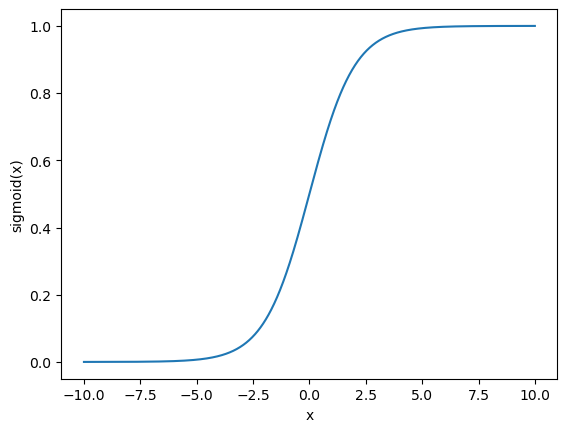

In [1144]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  return  1/(1+torch.exp(-z))


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [1145]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    return sigmoid(torch.matmul(x, self.weight.T))

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [1146]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  return torch.mean((-y_true * torch.log(y_pred)) - ((1-y_true) * torch.log(1-y_pred)))

In [1147]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight  
  weight -= lr * torch.sum(torch.matmul((y_pred-y).T, X), dim=0)
  model.weight = nn.Parameter(weight, requires_grad=False)

In [1148]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)

  print(cost_lst)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))
  return model.parameters()

[tensor(0.6931), tensor(0.1882), tensor(0.1451), tensor(0.1222), tensor(0.1076), tensor(0.0971), tensor(0.0892), tensor(0.0829), tensor(0.0778), tensor(0.0736), tensor(0.0699), tensor(0.0668), tensor(0.0640), tensor(0.0615), tensor(0.0594), tensor(0.0574), tensor(0.0556), tensor(0.0540), tensor(0.0525), tensor(0.0511), tensor(0.0498), tensor(0.0486), tensor(0.0475), tensor(0.0465), tensor(0.0455), tensor(0.0446), tensor(0.0437), tensor(0.0429), tensor(0.0421), tensor(0.0414), tensor(0.0407), tensor(0.0401), tensor(0.0394), tensor(0.0388), tensor(0.0383), tensor(0.0377), tensor(0.0372), tensor(0.0367), tensor(0.0362), tensor(0.0357), tensor(0.0353), tensor(0.0348), tensor(0.0344), tensor(0.0340), tensor(0.0336), tensor(0.0332), tensor(0.0329), tensor(0.0325), tensor(0.0322), tensor(0.0318), tensor(0.0315), tensor(0.0312), tensor(0.0309), tensor(0.0306), tensor(0.0303), tensor(0.0300), tensor(0.0298), tensor(0.0295), tensor(0.0292), tensor(0.0290), tensor(0.0288), tensor(0.0285), tensor(

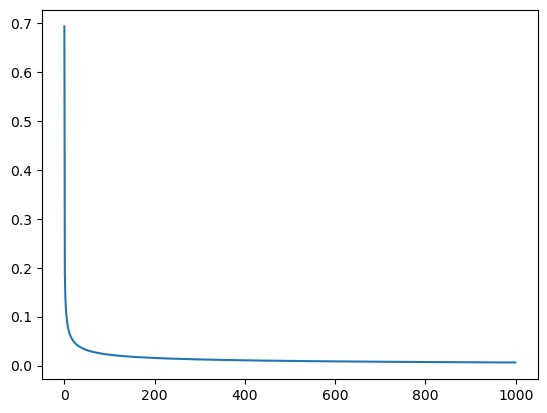

Parameter containing:
tensor([[-11.4330,   5.7506,  -7.0864]])
Minimum cost: 0.006341296713799238


In [1149]:
learning_rates = [0.0125, 0.025, 0.05, 0.125, 0.25, 0.3, 0.45, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 10, 100]

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.035 # select an appropriate lr
param = train(model, train_set_1, setosa_train, alpha)

<u><font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font></u>

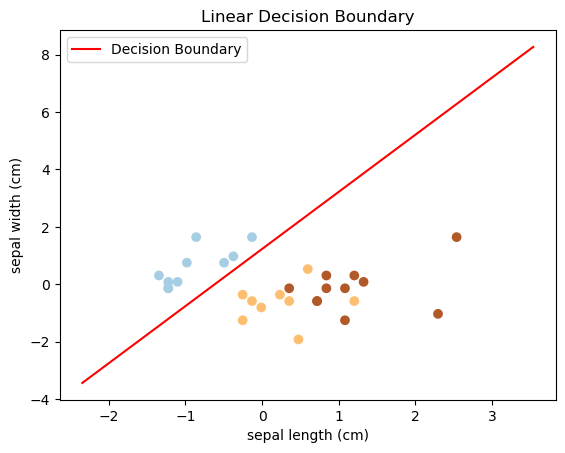

In [1150]:
w1, w2, bias = model.weight[0]

# Plotting the points
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test[:, 0], cmap=plt.cm.Paired, marker='o')

# Plotting the decision boundary
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
xx = torch.tensor([x_min, x_max])
yy = (-bias - w1 * xx) / w2
# plt.plot(xx, yy, color='red', label='Decision Boundary' )
plt.plot(xx, yy, color='red', label='Decision Boundary')

# Setting labels and title
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Linear Decision Boundary')

# Display the plot
plt.legend()
plt.show()


## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [1151]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [1152]:
def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))

### Setosa

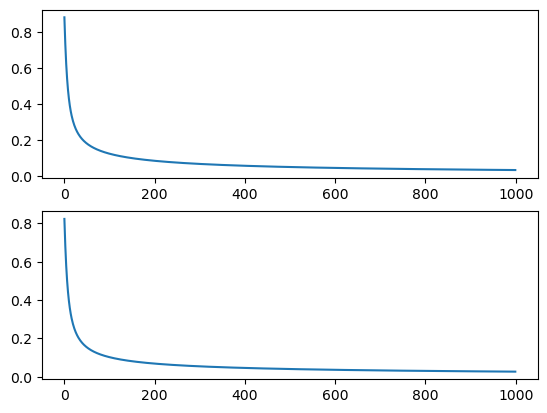

Minimum train cost: 0.03254665434360504
Minimum test cost: 0.027277670800685883


In [1153]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

### Versicolour

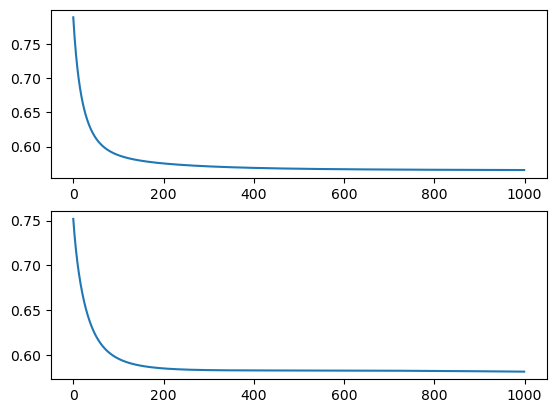

Minimum train cost: 0.5658299326896667
Minimum test cost: 0.5814474821090698


In [1154]:
alpha = 0.1
versicolour_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolour_labels = y_train[:, 1].reshape(-1, 1).float()
versicolour_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolour_model.parameters(), alpha)

train(versicolour_model, x_train, versicolour_labels, x_test, versicolour_testy, optimiser, alpha)

### verginica

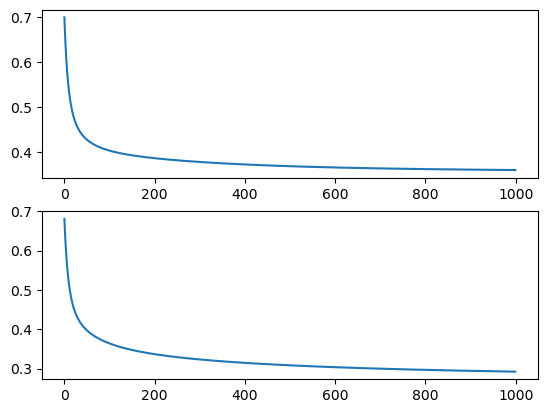

Minimum train cost: 0.3604441285133362
Minimum test cost: 0.29205185174942017


In [1155]:
alpha = 0.1
verginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
verginica_labels = y_train[:, 2].reshape(-1, 1).float()
verginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(verginica_model.parameters(), alpha)

train(verginica_model, x_train, verginica_labels, x_test, verginica_testy, optimiser, alpha)

<u><font color="red"> **Q6.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font></u>

In [1156]:
### your code here
verginica_pred = verginica_model(x_test)
versicolour_pred = versicolour_model(x_test)
setosa_pred = setosa_model(x_test)

In [1157]:
concat = torch.cat([verginica_pred, versicolour_pred, setosa_pred], dim=1)
concat.shape

torch.Size([30, 3])

In [1158]:
predictions = torch.argmax(concat, dim=1).unsqueeze(dim=1)
predictions.shape

torch.Size([30, 1])

In [1159]:
target = torch.argmax(y_test, dim=1).unsqueeze(dim=1)

In [1160]:
df = pd.DataFrame(
    torch.cat([concat, predictions, target], dim=1).detach().numpy(), 
    columns=['verginica_predictions', 'versicolour_predictions', 'setosa_predictions', 'class_prediction', 'y_test']
)
df

,verginica_predictions,versicolour_predictions,setosa_predictions,class_prediction,y_test
0,0.447611,0.762323,0.035093,1.0,1.0
1,0.109546,0.166916,0.999956,2.0,0.0
2,0.946576,0.836062,0.000003,0.0,2.0
3,0.706330,0.592832,0.038526,0.0,1.0
4,0.530905,0.762203,0.007007,1.0,1.0
5,0.082084,0.293683,0.999631,2.0,0.0
6,0.533346,0.535549,0.284369,1.0,1.0
7,0.970934,0.332411,0.001745,0.0,2.0
8,0.391441,0.907103,0.000404,1.0,1.0
9,0.373138,0.730151,0.075381,1.0,1.0


<u><font color="red"> **Q7.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font></u>

In [1161]:
pred = torch.cat((setosa_pred, versicolour_pred, verginica_pred), dim=1)
len(list(filter(lambda x: x==True, torch.argmax(F.softmax(pred, dim=1), dim=1) == torch.argmax(y_test, dim=1))))/len(y_test)  

0.9

## 3. The XOR problem

<u><font color="red"> **Q8.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font></u>

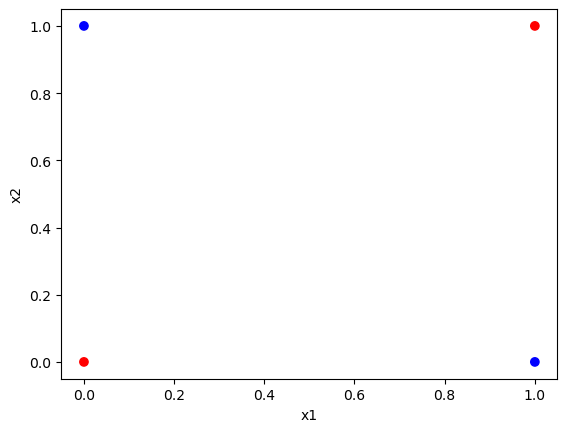

In [1162]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()